In [26]:
from sklearn.cluster import KMeans
from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math

In [27]:
# from https://github.com/lovro-i/CIEDE2000/tree/master
def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

In [28]:
def k_means_extraction(arr, height, width, palette_size):
    """
    Extracts a color palette using KMeans.
    :param arr: pixel array (height, width, 3)
    :param height: height
    :param width: width
    :param palette_size: number of colors
    :return: a palette of colors sorted by frequency
    """
    arr = np.reshape(arr, (width * height, -1))
    model = KMeans(n_clusters=palette_size, n_init=10, max_iter = 600)#, random_state=0)
    labels = model.fit_predict(arr)
    palette = np.array(model.cluster_centers_, dtype='uint8')
    color_count = np.bincount(labels)
    color_frequency = color_count / float(np.sum(color_count))
    colors = []
    freqs = []
    for color, freq in (zip(palette, color_frequency)):
        colors.append(color)
        freqs.append(freq)
    return np.array(colors), np.array(freqs)


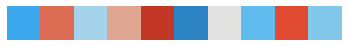

In [29]:
img= np.array(Image.open('pal1.png').convert('RGB')) #.resize((256,256), Image.NEAREST))
palette, freqs=k_means_extraction(img,785, 340, 10)
#s = np.flip([x for y, x in sorted(zip(freqs, palette))],axis=0)
s = palette
pal_lab_1 = color.rgb2lab(s)

plt.imshow(s[None,:])
plt.axis('off')
plt.show()

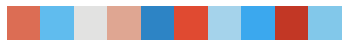

In [30]:
img2= np.array(Image.open('pal1.png').convert('RGB'))  #.resize((256,256), Image.BICUBIC))
palette2, freqs2=k_means_extraction(img2,785, 340,10)
#s2 = np.flip([x for y, x in sorted(zip(freqs2, palette2))],axis=0) #if y >0.012
s2 = palette2
pal_lab_2 = color.rgb2lab(s2)

plt.imshow(s2[None,:])
plt.axis('off')
plt.show()

In [31]:
mins1 =[]
for lab1 in pal_lab_1:
    min_1 = 100
    for lab2 in pal_lab_2:
        curr1 = CIEDE2000(lab1, lab2)
        if curr1 < min_1:
            min_1 = curr1
    mins1.append(min_1)
    
m1 = sum(mins1)/len(mins1)

mins2 = []
for lab2 in pal_lab_2:
    min_2 = 100
    for lab1 in pal_lab_1:
        curr2 = CIEDE2000(lab2, lab1)
        if curr2 < min_2:
            min_2 = curr2
    mins2.append(min_2)

m2 = sum(mins2)/len(mins2)

print(f'm: {(m1+m2)/2}')
        

m: 0.0


In [117]:
m_tot_1 = []
for i in range(180):    
    img= np.array(Image.open(f'cartoon_input/{i}.png').convert('RGB')) #.resize((256,256), Image.NEAREST))
    palette, freqs=k_means_extraction(img,256, 256, 5)
    #s = np.flip([x for y, x in sorted(zip(freqs, palette))],axis=0)
    s = palette
    pal_lab_1 = color.rgb2lab(s)


    img2= np.array(Image.open(f'inf/nearest/{i}.png').convert('RGB'))  #.resize((256,256), Image.BICUBIC))
    palette2, freqs2=k_means_extraction(img2,64, 64, 5)
    s2 = palette2
    pal_lab_2 = color.rgb2lab(s2)

    mins1 =[]
    for lab1 in pal_lab_1:
        min_1 = 100
        for lab2 in pal_lab_2:
            curr1 = CIEDE2000(lab1, lab2)
            if curr1 < min_1:
                min_1 = curr1
        mins1.append(min_1)

    m1 = sum(mins1)/len(mins1)

    mins2 = []
    for lab2 in pal_lab_2:
        min_2 = 100
        for lab1 in pal_lab_1:
            curr2 = CIEDE2000(lab2, lab1)
            if curr2 < min_2:
                min_2 = curr2
        mins2.append(min_2)

    m2 = sum(mins2)/len(mins2)
    m = (m1+m2)/2
    m_tot_1.append(m)
    if i % 10 == 0:
        print(f'{i} images done.')
m_tot_1

0 images done.
10 images done.
20 images done.
30 images done.
40 images done.
50 images done.
60 images done.
70 images done.
80 images done.
90 images done.
100 images done.
110 images done.
120 images done.
130 images done.
140 images done.
150 images done.
160 images done.
170 images done.


[0.6376148220361879,
 0.825930986908616,
 2.079333710926951,
 1.1483798714110107,
 0.38436590995349573,
 4.239902996636156,
 0.4596243149823951,
 0.2838789558263984,
 0.6746660076592701,
 0.6381496644887934,
 1.164735043640063,
 0.9642985464300142,
 3.409549062284553,
 0.43558519718222366,
 7.940001685371616,
 0.8697284436500918,
 0.487753374621557,
 1.189662482778265,
 0.5806985030669272,
 2.8935902405075646,
 1.7814453481035504,
 1.205029232280132,
 0.9236553094195031,
 0.9994839722151033,
 0.3265594573392997,
 0.8231990453788562,
 0.5931251323387869,
 0.9908480323252281,
 0.8742963677638043,
 0.6589269552354252,
 0.21479802175948945,
 1.8819811729974951,
 0.43520346298308593,
 0.2711143067504777,
 1.5847876911182421,
 0.34491782428408674,
 0.5108135569101406,
 1.118002989897686,
 0.3803377066556604,
 1.0174744692124449,
 0.6559084121709357,
 0.7821195008660039,
 1.1780413937582694,
 0.4448204070748957,
 0.6261541286278991,
 0.8596916093731467,
 0.5914228256810868,
 5.178998550751491

In [118]:
print(sum(m_tot_1)/len(m_tot_1))

1.21603498772087


In [114]:
def mean(data):
  n = len(data)
  mean = sum(data) / n
  return mean
 
def variance(data):
  n = len(data)
  mean = sum(data) / n
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / n
  return variance
 
def stdev(data):
  import math
  var = variance(data)
  std_dev = math.sqrt(var)
  return std_dev
 
data = np.array([7,5,4,9,12,45])

In [115]:
arra = np.array(m_tot_1)

In [116]:
print(mean(arra))
print(stdev(arra))

1.846524386679822
1.1632185975603966
